# Import thư viện

In [39]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Định nghĩa các hàm tiền xử lý

*Hàm tiền xử lý dữ liệu*

In [40]:
def extracting(df):
    # Xóa các cột không cần thiết
    df.drop(['link'], axis=1, inplace=True)

    # Chuyển đổi kiểu dữ liệu của cột 'genres' từ list sang string
    df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
    df['genres'] = df['genres'].apply(lambda x: sorted(x))
    df['genres'] = df['genres'].apply(lambda x: ','.join(x))
    
    return df

*Hàm chuyển đổi dữ liệu về dạng số*

In [41]:
def string_to_num(X_train, X_val, X_test, col):
    # Khởi tạo Label Encoder
    le = LabelEncoder()
    
    # Nếu cột trong tập train không có giá trị nào trong tập test thì thay thế bằng 'Unknown'
    for i in X_test[col].unique():
        if i not in X_train[col].unique():
            X_test[col].replace(i, 'Unknown', inplace=True)

    # Nếu cột trong tập train không có giá trị nào trong tập val thì thay thế bằng 'Unknown'
    for i in X_val[col].unique():
        if i not in X_train[col].unique():
            X_val[col].replace(i, 'Unknown', inplace=True)

    data = np.append(np.array(X_train[col].copy()), 'Unknown')

    # Fit Label Encoder
    le.fit(data)
    X_train[col] = le.transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
    X_test[col] = le.transform(X_test[col])

    return X_train, X_val, X_test

*Hàm xử lí dữ liệu trống*

In [42]:
def fillMissingData(data_train, data_val, data_test):
    # Các cột có giá trị trống
    eod_columns = ['publish_year', 'num_pages', 'page_format', 'publisher_count']
    eod_values = [data_train[col].mean() + 3*data_train[col].std() for col in eod_columns]
    for col, val in zip(eod_columns, eod_values):
        data_train[col].fillna(val, inplace=True)
        data_val[col].fillna(val, inplace=True)
        data_test[col].fillna(val, inplace=True)
    return data_train, data_val, data_test

*Hàm vẽ biểu đồ*

In [43]:
# Biểu đồ phân phối của các cột
def plotDistribution(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes] 
    for col, ax in zip(columns, axes):
        ax.hist(data[col], bins=50)
        ax.set_title(col)
    plt.show()  

# Biểu đồ box của các cột
def plotBox(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    for col, ax in zip(columns, axes):
        ax.boxplot(data[col])
        ax.set_title(col)
    plt.show()

*In ra các thông số đánh giá*

In [44]:
def printDescription(data, columns):
    for col in columns:
        print(data[col].describe())

*Hàm xử lí ngoại lệ*

In [45]:
def handleOutlier(data_train, data_val, data_test, skewedDists, gaussionDists):
    for col in skewedDists:
        IQR=data_train[col].quantile(0.75) - data_train[col].quantile(0.25)
        lower_bridge=data_train[col].quantile(0.25) - (IQR*3)
        upper_bridge=data_train[col].quantile(0.75) + (IQR*3)
        if skewedDists[col]:
            data_train.loc[data_train[col]>=upper_bridge,col]=upper_bridge
            data_val.loc[data_val[col]>=upper_bridge,col]=upper_bridge
            data_test.loc[data_test[col]>=upper_bridge,col]=upper_bridge
        else:
            data_train.loc[data_train[col]<=lower_bridge,col]=lower_bridge
            data_val.loc[data_val[col]<=lower_bridge,col]=lower_bridge
            data_test.loc[data_test[col]<=lower_bridge,col]=lower_bridge
        
    for col in gaussionDists:
        upper_boundary=data_train[col].mean() + 3 * data_train[col].std()
        lower_boundary=data_train[col].mean() - 3 * data_train[col].std()
        if gaussionDists[col]:
            data_train.loc[data_train[col]>=upper_boundary,col]=upper_boundary
            data_val.loc[data_val[col]>=upper_boundary,col]=upper_boundary
            data_test.loc[data_test[col]>=upper_boundary,col]=upper_boundary
        else:
            data_train.loc[data_train[col]<=lower_boundary,col]=lower_boundary
            data_val.loc[data_val[col]<=lower_boundary,col]=lower_boundary
            data_test.loc[data_test[col]<=lower_boundary,col]=lower_boundary
    return data_train, data_val, data_test

*Hàm chuẩn hóa dữ liệu với PowerTransformer*

In [46]:
def scaleData(data_train, data_val, data_test, scaler = PowerTransformer()):
    scaler.fit(data_train)
    data_train = pd.DataFrame(scaler.transform(data_train.copy()), columns=data_train.columns)
    data_val = pd.DataFrame(scaler.transform(data_val.copy()), columns=data_val.columns)
    data_test = pd.DataFrame(scaler.transform(data_test.copy()), columns=data_test.columns)
    return data_train, data_val, data_test

*Hàm chọn đặc trưng với SelectKBest*

In [47]:
def selectFeatures_SelectKBest(X_train, y_train, X_val, X_test):
    X_kbest = SelectKBest(f_classif, k = 18).fit(X_train, y_train)
    ix = X_kbest.get_support() 
    data = pd.DataFrame(X_kbest.transform(X_train), columns = X_train.columns.values[ix])

    print(data.columns.values)
    featureArray = data.columns.values

    X_train = X_train[featureArray]
    X_val = X_val[featureArray]
    X_test = X_test[featureArray]
    return X_train, X_val, X_test

*Hàm chọn đặc trưng với RFE*

In [48]:
def selectFeatures(X_train, y_train, X_val, X_test):
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=18, step=1)
    selector = selector.fit(X_train, y_train)
    ix = selector.get_support() 
    data = pd.DataFrame(selector.transform(X_train), columns = X_train.columns.values[ix])

    print(data.columns.values)
    featureArray = data.columns.values

    X_train = X_train[featureArray]
    X_val = X_val[featureArray]
    X_test = X_test[featureArray]
    return X_train, X_val, X_test

# Feature Engineering

*Chuẩn bị dữ liệu*

In [49]:
df=pd.read_csv('data_1000.csv')
df.head()

,title,author,language,avg_ratings,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres,link
0,Fireproof,Eric Wilson,English,4.47,52871,616,Thomas Nelson Publishers,2008.0,284.0,Paperback,"['Christian', 'Christian Fiction', 'Fiction', ...",https://www.goodreads.com/book/show/3412815-fi...
1,Crank,Ellen Hopkins,English,4.16,139194,8919,Margaret K. McElderry Books,2004.0,537.0,Paperback,"['Young Adult', 'Poetry', 'Fiction', 'Contempo...",https://www.goodreads.com/book/show/270730.Crank
2,الحرافيش,Naguib Mahfouz,Arabic,4.38,16833,2423,دار الشروق,2006.0,599.0,Paperback,"['Novels', 'Fiction', 'Literature', 'Egypt', '...",https://www.goodreads.com/book/show/5295735
3,"He, She and It",Marge Piercy,English,3.98,5538,466,Fawcett,1993.0,448.0,Mass Market Paperback,"['Science Fiction', 'Fiction', 'Dystopia', 'Ro...",https://www.goodreads.com/book/show/788331.He_...
4,Independent People,Halldór Laxness,English,4.15,11334,1580,Vintage,1997.0,482.0,Paperback,"['Fiction', 'Classics', 'Historical Fiction', ...",https://www.goodreads.com/book/show/77287.Inde...


*Kiểm tra sự trùng lặp của dữ liệu*

In [50]:
# check for duplications
print(f"Number of duplicated rows: {df.duplicated().any().sum()}")
if df.duplicated().any().sum() > 0:
    df.drop_duplicates(inplace=True)

Number of duplicated rows: 0


*Kiểm tra dữ liệu bị trống*

In [51]:
# check for missing values
print(f"Number of missing values: \n{df.isnull().sum()}")

Number of missing values: 
title             0
author            0
language         29
avg_ratings       0
ratings_count     0
reviews_count     0
publisher        41
publish_year      4
num_pages        14
page_format       5
genres            0
link              0
dtype: int64


*Tiền xử lý dữ liệu*

In [52]:
df = extracting(df)
df.head()

,title,author,language,avg_ratings,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres
0,Fireproof,Eric Wilson,English,4.47,52871,616,Thomas Nelson Publishers,2008.0,284.0,Paperback,"Christian,Christian Fiction,Contemporary,Faith..."
1,Crank,Ellen Hopkins,English,4.16,139194,8919,Margaret K. McElderry Books,2004.0,537.0,Paperback,"Banned Books,Contemporary,Fiction,High School,..."
2,الحرافيش,Naguib Mahfouz,Arabic,4.38,16833,2423,دار الشروق,2006.0,599.0,Paperback,"Africa,Classics,Egypt,Egyptian Literature,Fict..."
3,"He, She and It",Marge Piercy,English,3.98,5538,466,Fawcett,1993.0,448.0,Mass Market Paperback,"Cyberpunk,Dystopia,Fantasy,Feminism,Fiction,Je..."
4,Independent People,Halldór Laxness,English,4.15,11334,1580,Vintage,1997.0,482.0,Paperback,"20th Century,Classics,Fiction,Historical,Histo..."


*Tách dữ liệu thành tập dữ liệu và nhãn tương ứng(avg_ratings)*

In [53]:
data = df.copy()
y = data['avg_ratings']
X = data.drop(['avg_ratings'], axis=1)

*Chia dữ liệu thành tập train, val và test*

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

*Tính tổng số lượng các thể loại*

In [55]:
total_genres = []
for genres in X_train['genres']:
    for genre in genres.split(','):
        total_genres.append(genre)
total_genres = set(total_genres)
print(f"Total genres: {len(total_genres)}")

Total genres: 382


*Lấy ra top 20 thể loại phổ biến nhất*

In [56]:
all_genres = []
for genres in X_train['genres']:
    for genre in genres.split(','):
        all_genres.append(genre)

# Đếm số lượng mỗi thể loại
genre_counts = pd.Series(all_genres).value_counts().to_dict()

top_20_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:20]
print(f"Top 20 genres: {top_20_genres}")

Top 20 genres: [('Fiction', 513), ('Fantasy', 292), ('Romance', 252), ('Young Adult', 221), ('Audiobook', 173), ('Novels', 156), ('Classics', 153), ('Contemporary', 153), ('Adult', 131), ('Adventure', 129), ('Literature', 123), ('Historical Fiction', 116), ('Mystery', 110), ('Paranormal', 108), ('Science Fiction', 105), ('Magic', 94), ('Historical', 93), ('Urban Fantasy', 79), ('Nonfiction', 77), ('Supernatural', 75)]


*Trực quan hóa top 20 thể loại phổ biến nhất*

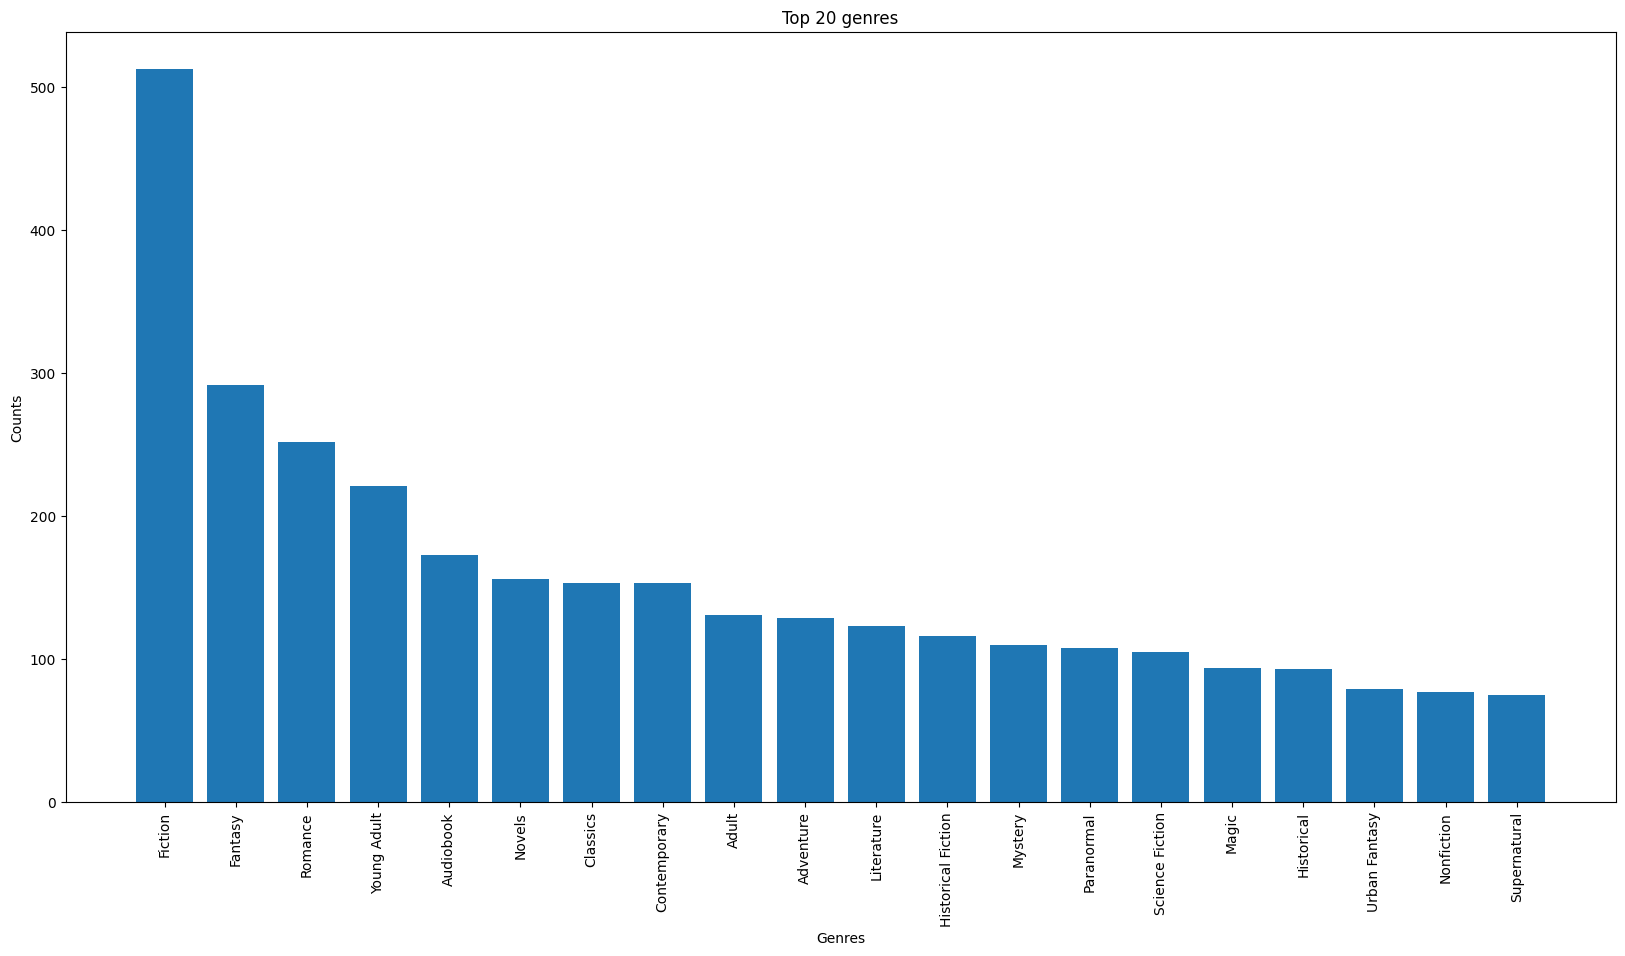

In [57]:
# Visualize top 20 genres
plt.figure(figsize=(20, 10))
plt.bar(range(len(top_20_genres)), [val[1] for val in top_20_genres], align='center')
plt.xticks(range(len(top_20_genres)), [val[0] for val in top_20_genres])
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.title('Top 20 genres')
plt.show()

*Thêm 20 thể loại phổ biến nhất vào tập dữ liệu*

In [58]:
top_20_genres_col = [genre[0] for genre in top_20_genres]

# Tạo cột cho mỗi thể loại
for genre in top_20_genres_col:
    X_train[genre] = X_train['genres'].apply(lambda x: 1 if genre in x else 0)
    X_val[genre] = X_val['genres'].apply(lambda x: 1 if genre in x else 0)
    X_test[genre] = X_test['genres'].apply(lambda x: 1 if genre in x else 0)

pd.set_option('display.max_columns', None)

X_train.head()

,title,author,language,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres,Fiction,Fantasy,Romance,Young Adult,Audiobook,Novels,Classics,Contemporary,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Science Fiction,Magic,Historical,Urban Fantasy,Nonfiction,Supernatural
390,"The Other Wes Moore: One Name, Two Fates",Wes Moore,English,47667,5447,One World,2010.0,233.0,Hardcover,"African American,Audiobook,Biography,Biography...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
847,Forgiven,Jana Oliver,English,8171,460,St. Martin's Griffin,2012.0,354.0,Paperback,"Angels,Demons,Fantasy,Fiction,Paranormal,Roman...",1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1
93,The Tales of Beedle the Bard,J.K. Rowling,English,470897,17760,Bloomsbury,2008.0,105.0,Hardcover,"Audiobook,Childrens,Fairy Tales,Fantasy,Fictio...",1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
236,The Power of Habit: Why We Do What We Do in Li...,Charles Duhigg,English,471948,21520,Random House,2012.0,375.0,Hardcover,"Audiobook,Business,Leadership,Nonfiction,Perso...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
858,The Cherry Orchard,Anton Chekhov,English,37952,1564,Bloomsbury Methuen Drama,2004.0,96.0,Paperback,"20th Century,Classics,Drama,Fiction,Literature...",1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


*Hàm tạo thêm các đặc trưng mới (title_count, title_length, publisher_count, rating_review_ratio, books_by_author, is_famous_author) và xóa các cột không cần thiết (title, author, publisher, language, genres)*

In [59]:
def addNewFeatures(data):
    data['title_count'] = data.groupby('title')['title'].transform('count')
    data.loc[data['reviews_count'] == 0, 'reviews_count'] = 1
    data['title_length'] = data['title'].apply(lambda x: len(x))
    data['publisher_count'] = data.groupby('publisher')['publisher'].transform('count')
    data['rating_review_ratio'] = data['ratings_count'] / data['reviews_count']
    data['books_by_author'] = data.groupby('author')['author'].transform('count')
    data['is_famous_author'] = data['books_by_author'].apply(lambda x: 1 if x > 10 else 0)

    drops = ['title', 'genres', 'author', 'publisher', 'language']
    for col in drops:
        data.drop([col], axis=1, inplace=True)

*Tạo thêm đặc trưng mới cho 3 tập dữ liệu*

In [60]:
addNewFeatures(X_train)
addNewFeatures(X_val)
addNewFeatures(X_test)

X_train.head()

,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Novels,Classics,Contemporary,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Science Fiction,Magic,Historical,Urban Fantasy,Nonfiction,Supernatural,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
390,47667,5447,2010.0,233.0,Hardcover,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,40,2.0,8.751056,1,0
847,8171,460,2012.0,354.0,Paperback,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,8,7.0,17.763043,1,0
93,470897,17760,2008.0,105.0,Hardcover,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,28,3.0,26.514471,2,0
236,471948,21520,2012.0,375.0,Hardcover,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,61,4.0,21.930669,1,0
858,37952,1564,2004.0,96.0,Paperback,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,18,1.0,24.265985,1,0


*Chuyển đổi cột dữ liệu 'page_format' về dạng số*

In [61]:
cols = ['page_format']
for col in cols:
    X_train, X_val, X_test = string_to_num(X_train, X_val, X_test, col)

X_train.head()

,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Novels,Classics,Contemporary,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Science Fiction,Magic,Historical,Urban Fantasy,Nonfiction,Supernatural,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
390,47667,5447,2010.0,233.0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,40,2.0,8.751056,1,0
847,8171,460,2012.0,354.0,7,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,8,7.0,17.763043,1,0
93,470897,17760,2008.0,105.0,2,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,28,3.0,26.514471,2,0
236,471948,21520,2012.0,375.0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,61,4.0,21.930669,1,0
858,37952,1564,2004.0,96.0,7,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,18,1.0,24.265985,1,0


*Trực quan hóa các đặc trưng với nhãn (avg_ratings)*

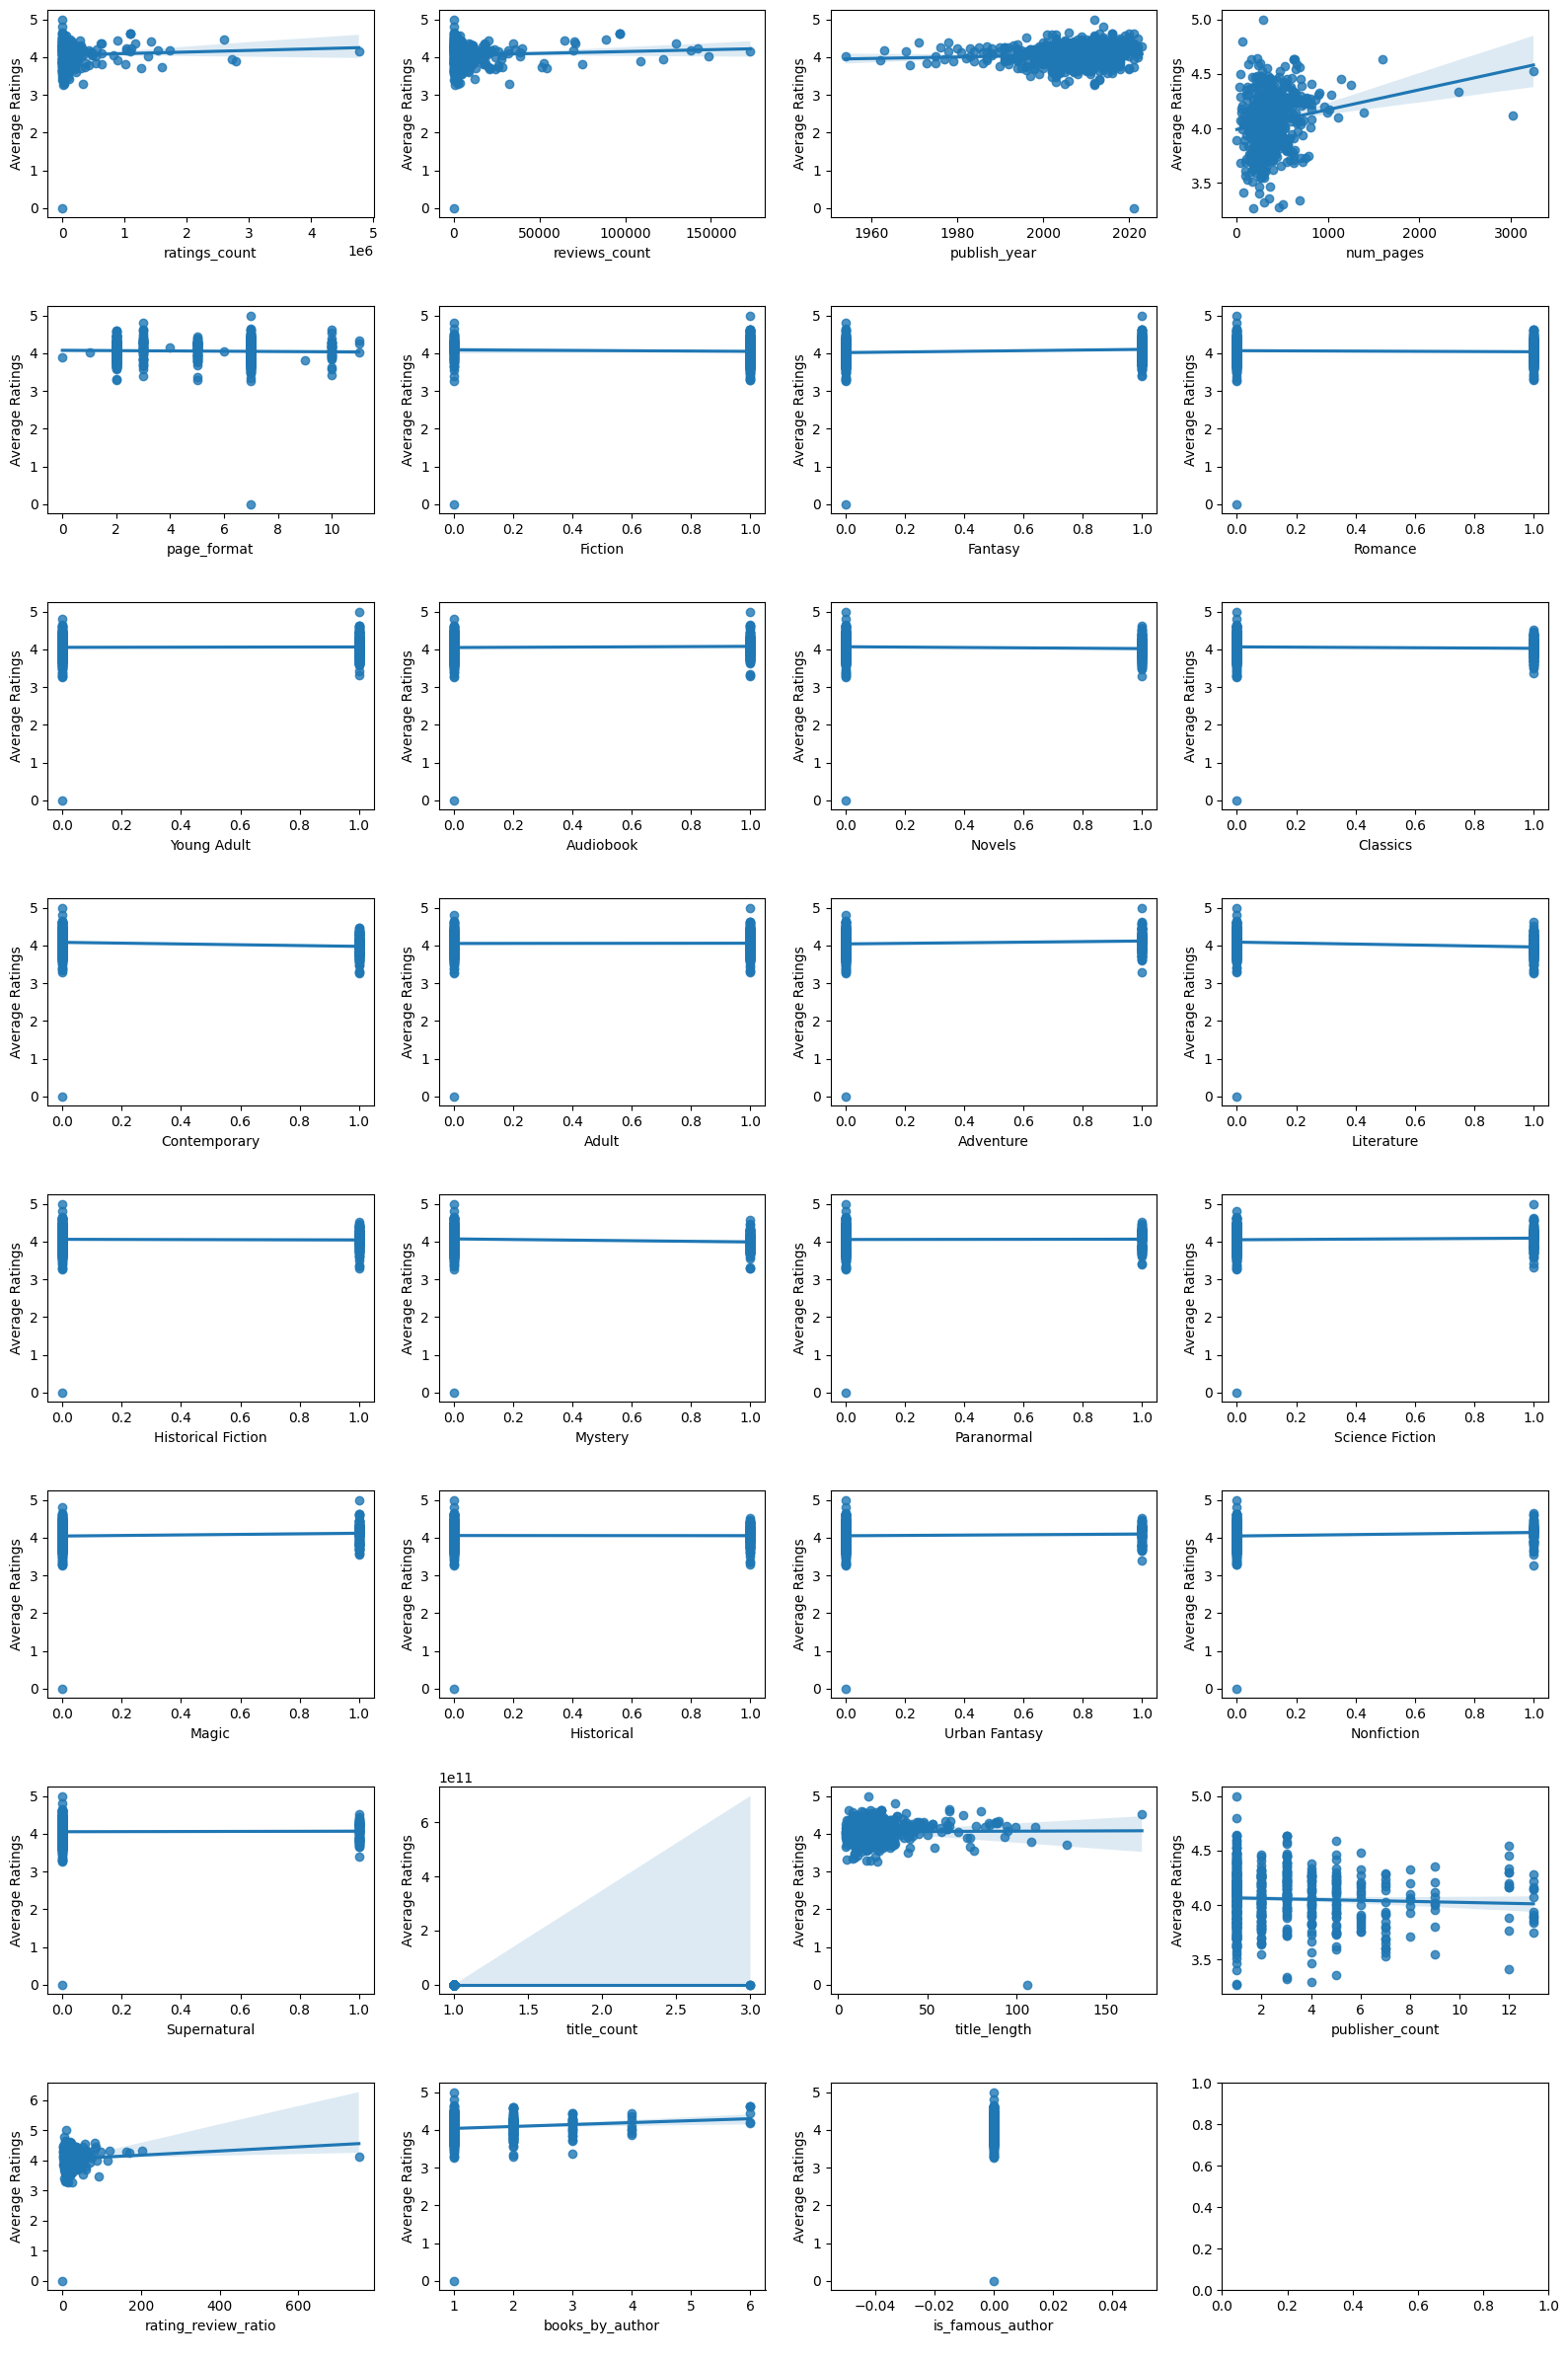

In [62]:
data_train = pd.concat([X_train, y_train], axis=1)
cols = data_train.columns.tolist()
cols.remove('avg_ratings')
cols_len = len(cols)
num_rows = cols_len // 4 + 1
fig, ax = plt.subplots(num_rows, 4, figsize=(16, 24))
for i in range(cols_len):
    sns.regplot(x=cols[i], y='avg_ratings', data=data_train, ax=ax[i // 4][i % 4])
    ax[i // 4][i % 4].set_xlabel(cols[i] + '\n')
    ax[i // 4][i % 4].set_ylabel('Average Ratings')

plt.tight_layout()
plt.show()

*Heatmap thể hiện sự tương quan giữa nhãn (avg_ratings) và các đặc trưng*

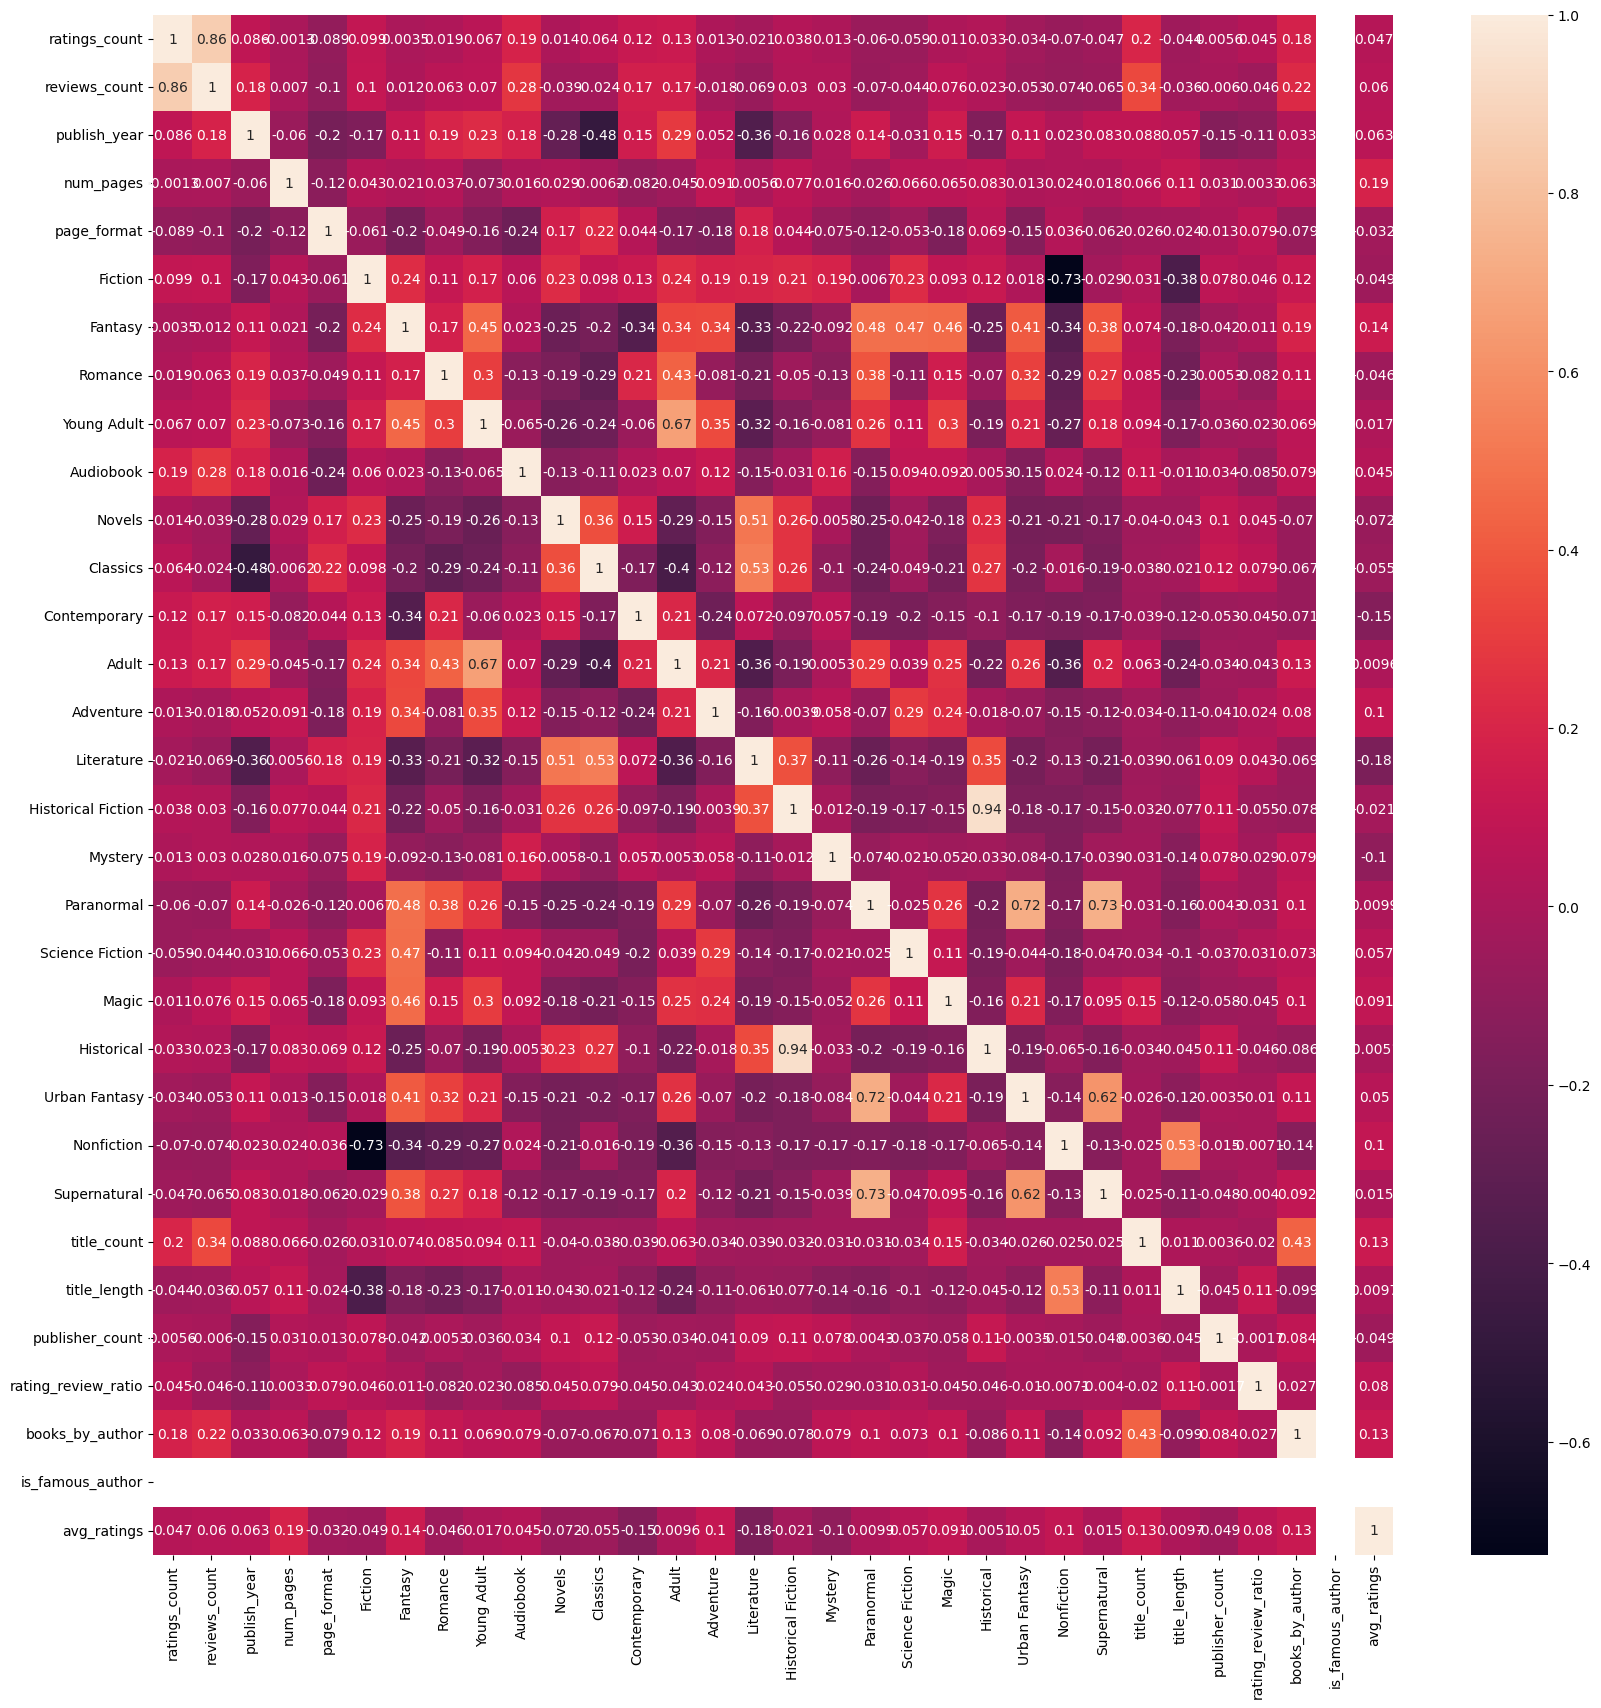

In [63]:
def plot_heatmap(data):
    corr = data.corr()
    plt.figure(figsize=(20, 20))

    sns.heatmap(corr, annot=True)
    plt.show()

plot_heatmap(data_train)

*Lấy ra các đặc trưng có độ tương quan cao với nhãn (avg_ratings)*

In [64]:
corr = data_train.corr()
corr['avg_ratings'].sort_values(ascending=False)

avg_ratings            1.000000
num_pages              0.185135
Fantasy                0.141370
title_count            0.132539
books_by_author        0.129351
Adventure              0.103127
Nonfiction             0.101556
Magic                  0.090733
rating_review_ratio    0.080006
publish_year           0.062536
reviews_count          0.059759
Science Fiction        0.056895
Urban Fantasy          0.049882
ratings_count          0.046592
Audiobook              0.045034
Young Adult            0.016988
Supernatural           0.014627
Paranormal             0.009902
title_length           0.009737
Adult                  0.009632
Historical            -0.005116
Historical Fiction    -0.021409
page_format           -0.032198
Romance               -0.046438
Fiction               -0.049298
publisher_count       -0.049415
Classics              -0.055370
Novels                -0.072197
Mystery               -0.101541
Contemporary          -0.153189
Literature            -0.183800
is_famou

*Kiểm tra dữ liệu trống*

In [65]:
X_train.isnull().sum()

ratings_count           0
reviews_count           0
publish_year            1
num_pages               8
page_format             0
Fiction                 0
Fantasy                 0
Romance                 0
Young Adult             0
Audiobook               0
Novels                  0
Classics                0
Contemporary            0
Adult                   0
Adventure               0
Literature              0
Historical Fiction      0
Mystery                 0
Paranormal              0
Science Fiction         0
Magic                   0
Historical              0
Urban Fantasy           0
Nonfiction              0
Supernatural            0
title_count             0
title_length            0
publisher_count        24
rating_review_ratio     0
books_by_author         0
is_famous_author        0
dtype: int64

*Xử lí dữ liệu trống với các cột (publish_year, num_pages, publisher_count)*

In [66]:
X_train, X_val, X_test = fillMissingData(X_train, X_val, X_test)
X_train.head()

,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Novels,Classics,Contemporary,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Science Fiction,Magic,Historical,Urban Fantasy,Nonfiction,Supernatural,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
390,47667,5447,2010.0,233.0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,40,2.0,8.751056,1,0
847,8171,460,2012.0,354.0,7,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,8,7.0,17.763043,1,0
93,470897,17760,2008.0,105.0,2,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,28,3.0,26.514471,2,0
236,471948,21520,2012.0,375.0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,61,4.0,21.930669,1,0
858,37952,1564,2004.0,96.0,7,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,18,1.0,24.265985,1,0


*Vẽ biểu đồ phân phối và biểu đồ box để xác định ngoại lệ của dữ liệu*

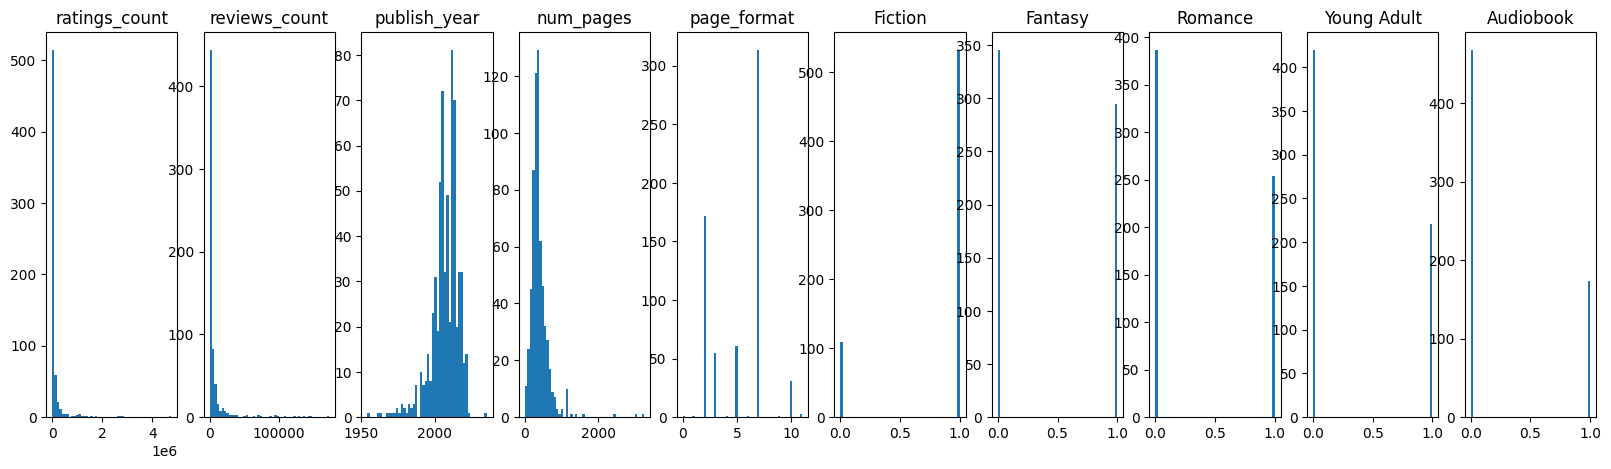

In [67]:
cols = X_train.columns
for i in range(0, 3):
    plotDistribution(X_train, cols[i*10: (i+1)*10])
    plotBox(X_train, cols[i*10: (i+1)*10])

*Nhận xét:*
- Từ các biểu đồ trên ta thấy hầu hết các đặc trưng đều có nhiều ngoại lệ và phân phối không đều.
- Đa số các ngoại lệ này có dạng phân phối lệch
- Các đặc trưng có ngoại lệ bao gồm: ratings_count, reviews_count, publish_year, num_pages, Fiction, Classics, Adventure,
       Mystery, Historical Fiction, Literature, Paranormal, Historical, Science Fiction, Thriller, Magic, Nonfiction, Childrens, 
       title_count, publisher_count, rating_review_ratio, books_by_author, title_length

In [ ]:
skewedDists = ['ratings_count', 'reviews_count', 'publish_year', 'num_pages', 'Fiction', 'Classics', 'Contemporary', 'Adventure',
       'Mystery', 'Historical Fiction', 'Literature', 'Paranormal', 'Historical', 'Science Fiction', 'Historical', 'Urban Fantasy', 'Supernatural',
       'Magic', 'Nonfiction', 'title_count', 'publisher_count', 'rating_review_ratio', 'books_by_author', 'title_length']
isUpper_bridge = [True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
skewedDists = {col: isUpper_bridge for col, isUpper_bridge in zip(skewedDists, isUpper_bridge)}
gaussionDists = []
isUpper_boundary = []
gaussionDists = {col: isUpper_boundary for col, isUpper_boundary in zip(gaussionDists, isUpper_boundary)}

*Xử lí ngoại lệ*

In [ ]:
X_train, X_val, X_test = handleOutlier(X_train, X_val, X_test, skewedDists, gaussionDists)
X_train.head()

*Vẽ biểu đồ phân phối sau khi xử lí ngoại lệ*

In [ ]:
cols = X_train.columns
for i in range(0, 3):
    plotDistribution(X_train, cols[i*10: (i+1)*10])
    plotBox(X_train, cols[i*10: (i+1)*10])

*Nhận xét:*
- Sau khi xử lí ngoại lệ, phân phối của các đặc trưng đã được cải thiện đáng kể
- Tuy nhiên, vẫn còn một số đặc trưng có phân phối không đều và có nhiều ngoại lệ (ratings_count, reviews_count, publish_year, ...)

*Chuẩn hóa dữ liệu với PowerTransformer*

In [ ]:
X_train, X_val, X_test = scaleData(X_train, X_val, X_test, PowerTransformer())
X_train.head()

*Vẽ biểu đồ phân phối sau khi chuẩn hóa dữ liệu*

In [ ]:
cols = X_train.columns
for i in range(0, 3):
    plotDistribution(X_train, cols[i*10: (i+1)*10])

*Nhận xét:*
- Sau khi chuẩn hóa dữ liệu, phân phối của các đặc trưng đã được cải thiện đáng kể đặc biệt là các đặc trưng như là: ratings_count, reviews_count, publish_year, num_pages, ...
- Tuy nhiên, vẫn còn một số đặc trưng có phân phối không đều và có nhiều ngoại lệ
- Đặc biệt, các đặc trưng như là: Fiction, Classis, Adventure, Literature, Historical Fiction, Literature, Paranormal, Historical, Science Fiction, Thriller, Magic, Nonfiction, Childrens, title_count có giá trị gần bằng 0. Điều này cho thấy các đặc trưng này không có tác dụng đối với nhãn (avg_ratings)

*Chọn đặc trưng với SelectKBest*

In [ ]:
X_train_SF_SKB, X_val_SF_SKB, X_test_SF_SKB = selectFeatures_SelectKBest(X_train, y_train, X_val, X_test)
X_train_SF_SKB.head()

*Chọn đặc trưng với RFE*

In [ ]:
X_train_SF, X_val_SF, X_test_SF = selectFeatures(X_train, y_train, X_val, X_test)
X_train_SF.head()

*Nhận xét:*
- Các đặc trưng được chọn bởi SelectKBest và RFE là gần giống nhau và đều có độ tương quan cao với nhãn (avg_ratings)
- Với SelectKBest, ta chọn ra 18 đặc trưng có độ tương quan cao nhất với nhãn (avg_ratings): ratings_count, reviews_count, publish_year, num_pages, page_format,
Fantasy, Romance, Young Adult, Audiobook, Contemporary, Novels, Adult, title_count, title_length, publisher_count, rating_review_ratio, books_by_author,is_famous_author
- Với RFE, ta chọn ra 18 đặc trưng có độ tương quan cao nhất với nhãn (avg_ratings): ratings_count, reviews_count, publish_year, num_pages, page_format,
Fiction, Fantasy, Romance, Young Adult, Audiobook, Contemporary, Novels Adult, title_length, publisher_count, rating_review_ratio, books_by_author,is_famous_author

# MODEL

Lấy các tập X_train,X_test,X_val khi chưa select đạc trưng và khi đã select đặc trưng

In [ ]:
#Tập X train khi chưa chọn đặc trưng
X_train_RF = X_train.copy()
X_train_SVM = X_train.copy()
X_train_best_RF = X_train.copy()
X_train_best_SVM = X_train.copy()

#Tập Xtrain khi đã chọn đặc trưng
X_train_SF_RF = X_train_SF.copy()
X_train_SKB_RF = X_train_SF_SKB.copy()
X_train_SF_SVM = X_train_SF.copy()
X_train_best_SF_RF = X_train_SF.copy()
X_train_best_SF_SVM = X_train_SF.copy()


In [ ]:
X_train_SF.head()

In [ ]:
rs = []
rs_sf = []
rs_sf_best = []
rs_test_final = []
label = ['Random Forest Regression', 'Support Vector Regression']
# result = pd.DataFrame(result, columns=['MAE', 'RMSE', 'R2score'], index=label)

Train model mặc định

In [ ]:
def trainDefaultModel(model, X_train, y_train, X_val):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    return y_pred

Vẽ sự tương quan giữa giá trị dự đoán và thực tế

In [ ]:
def plotValue(y_test, y_pred):
  ind = list(range(1, 151))
  fig, axs = plt.subplots(1, 1, figsize=(20, 6), sharey=True)
  axs.plot(ind, y_pred[:150], label='Predicted Value', color='blue')
  axs.plot(ind, y_test[:150], label='True Value', color='green')
  axs.legend()
  axs.set_ylabel('Rating')
  fig.suptitle('Predicted Value - True Value')
  plt.show()

Đánh giá mô hình

Ý nghĩa các metric:
- MAE (Mean Absolute Error) : Thể hiện sự chênh lệch trung bình giữa giá trị dự đoán và giá trị thực tế. Giá trị này càng thấp thì mô hình càng chính xác.
- RMSE (Root Mean Squared Error) : Thể hiện độ lệch chuẩn giữa giá trị dự đoán và giá trị thực tế. Giá trị này càng thấp thì mô hình càng chính xác.
- R2 score (Coefficient of Determination) : Thể hiện độ giải thích của mô hình trên tổng phương sai của dữ liệu. Giá trị này càng gần 1 thì mô hình càng tốt.

In [ ]:
def accuracyScore(y_test, y_pred, isShow = True):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    r2score = r2_score(y_test, y_pred)
    MAE = round(MAE, 4)
    RMSE = round(RMSE, 4)
    r2score = round(r2score, 4)
    if isShow:
        print(
            f'MAE: \n{MAE}\n'
            f'RMSE: \n{RMSE}\n'
            f'R2 score: \n{r2score}\n'
        )
        plt.scatter(y_test, y_pred, color='red',alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue')
        plt.xlabel('True values')
        plt.xlabel('Predicted values')
        plt.axis('equal')
        plt.axis('square')
        plt.show()
    return MAE, RMSE, r2score

In [ ]:
def plot2Model(y_test_1,y_pred_1,y_test_2,y_pred_2):
    plt.figure()

    # Vẽ dữ liệu của model thứ nhất
    plt.scatter(y_test_1, y_pred_1, color='red', alpha=0.5)
    plt.plot([min(y_test_1), max(y_test_1)], [min(y_test_1), max(y_test_1)], color='blue')

    # Vẽ dữ liệu của model thứ hai
    plt.scatter(y_test_2, y_pred_2, color='blue', alpha=0.5)
    plt.plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], color='purple')

    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.axis('equal')
    plt.axis('square')
    plt.show()

## Random Forest

Khi chưa select đặc trưng

In [ ]:
rf = RandomForestRegressor()
y_pred_rf = trainDefaultModel(rf, X_train_RF, y_train, X_val)


In [ ]:
plotValue(y_val, y_pred_rf)
x, y, z = accuracyScore(y_val, y_pred_rf)
rs.append([x,y,z])

Sau khi select đặc trưng với kỹ thuật Select K Best

In [ ]:
rf = RandomForestRegressor()
y_pred_SF_rf = trainDefaultModel(rf, X_train_SKB_RF , y_train, X_val_SF_SKB)


In [ ]:
plotValue(y_val, y_pred_SF_rf)
x,y,z = accuracyScore(y_val, y_pred_SF_rf)

Sau khi select đặc trưng với kỹ thuật RFE

In [ ]:
rf = RandomForestRegressor()
y_pred_SF_rf = trainDefaultModel(rf, X_train_SF_RF , y_train, X_val_SF)


In [ ]:
plotValue(y_val, y_pred_SF_rf)
x,y,z = accuracyScore(y_val, y_pred_SF_rf)
rs_sf.append([x,y,z])

=> Cả 2 kỹ thuật đều mang lại hiệu suất tương đối giống nhau, sử dụng kỹ thuật RFE

## Khi chọn siêu tham số cho mô hình

Ý nghĩa các tham số của mô hình rf
- n_estimators:  số lượng cây trong mô hình.
- max_depth:  độ sâu tối đa của các cây.
- min_samples_split:  số lượng mẫu tối thiểu để phân tách một nút.
- min_samples_leaf:  số lượng mẫu tối thiểu trong một lá cây.
- max_features:  số lượng tính năng tối đa được sử dụng để tìm kiếm trên mỗi nút.

In [ ]:
#random forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 5, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
def findBestParams(model,param_grid, X_train, y_train):
    # Initialize GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    # Fit GridSearchCV on Validation set
    grid_search.fit(X_train, y_train)
    return grid_search

In [ ]:
# In ra bộ siêu tham số tối ưu
# Get best estimator from GridSearchCV
rf2 = RandomForestRegressor()
best_rf = findBestParams(rf2,param_grid_rf, X_train_best_SF_RF, y_train).best_params_
best_rf

In [ ]:
rs_sf_best = []
# Khởi tạo lại mô hình với các tham số tối ưu
rf_best_params = RandomForestRegressor(max_depth=best_rf['max_depth'], n_estimators=best_rf['n_estimators'], max_features=best_rf['max_features'], min_samples_split=best_rf['min_samples_split'], min_samples_leaf=best_rf['min_samples_leaf'], random_state=42 )

rf_best_params.fit(X_train_best_SF_RF, y_train)

# Sử dụng mô hình đã huấn luyện để dự đoán trên tập Val set
y_pred_best_rf = rf_best_params.predict(X_val_SF)

x,y,z = accuracyScore(y_val, y_pred_best_rf)
rs_sf_best.append([x,y,z])
plotValue(y_val, y_pred_best_rf)

=>Sử dụng mô hình mặc định với kỹ thuật chọn đặc trưng RFE để dự đoán trên tập test

In [ ]:
#Tập test
rf = RandomForestRegressor()
y_pred_SF_rf_final = trainDefaultModel(rf, X_train_SF_RF , y_train, X_test_SF)
plotValue(y_test, y_pred_SF_rf_final)
x,y,z = accuracyScore(y_test, y_pred_SF_rf_final)
rs_test_final.append([x,y,z])

## SVM

In [ ]:
# Khởi tạo mô hình SVM
svr = SVR()
y_pred_svm = trainDefaultModel(svr, X_train_SVM , y_train, X_val)

In [ ]:
plotValue(y_val, y_pred_svm)
x, y, z = accuracyScore(y_val,y_pred_svm)
rs.append([x,y,z])


Khi select đặc trưng

In [ ]:
svr = SVR()
y_pred_SF_svm = trainDefaultModel(svr, X_train_SF_SVM , y_train, X_val_SF)


In [ ]:
plotValue(y_val, y_pred_SF_svm)
x, y, z = accuracyScore(y_val, y_pred_SF_svm)
rs_sf.append([x,y,z])

Ý nghĩa các tham số:
- kernel: Là tham số quan trọng trong mô hình SVR, quyết định loại hàm kernel được sử dụng để tính toán độ tương đồng giữa các điểm dữ liệu
- C: Điều chỉnh mức độ giới hạn (regularization) trong mô hình SVR. Giá trị C càng cao, mô hình sẽ càng không chấp nhận sự vi phạm của các điểm dữ liệu, dẫn đến việc tạo ra một đường biên cực kỳ cứng (overfitting).
- gamma: Tham số này ảnh hưởng đến hình dạng của đường biên. Giá trị gamma nhỏ đồng nghĩa với đường biên trơn, trong khi gamma lớn tạo ra đường biên phức tạp và đi qua các điểm dữ liệu gần nó

In [ ]:
# Định nghĩa các tham số cần tinh chỉnh
param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

In [ ]:
# In ra bộ siêu tham số tối ưu
# Get best estimator from GridSearchCV
svr2 = SVR()
best_svr = findBestParams(svr2,param_grid_svr, X_train_best_SF_SVM, y_train).best_params_
best_svr

In [ ]:
# Khởi tạo lại mô hình với các tham số tối ưu

svr_best_params = SVR(kernel=best_svr['kernel'], C=best_svr['C'], gamma=best_svr['gamma'], epsilon=0.1)

svr_best_params.fit(X_train_best_SF_SVM, y_train)

# Sử dụng mô hình đã huấn luyện để dự đoán trên tập Val set
y_pred_best_svr = svr_best_params.predict(X_val_SF)

x,y,z = accuracyScore(y_val, y_pred_best_svr)
rs_sf_best.append([x,y,z])
plotValue(y_val, y_pred_best_svr)

In [ ]:
#Tập test
svr = SVR()
y_pred_SF_svm_final = trainDefaultModel(svr, X_train_SF_SVM , y_train, X_test_SF)
plotValue(y_test, y_pred_SF_svm_final)
x,y,z = accuracyScore(y_test, y_pred_SF_svm_final)
rs_test_final.append([x,y,z])
# rs_sf.append([x,y,z])

#  So Sánh

Kết quả của 2 mô hình khi chưa chọn đặc trưng

In [ ]:
rs = pd.DataFrame(rs, columns=['MAE', 'RMSE', 'R2score'], index=label)
rs

Kết quả của 2 mô hình khi đã chọn đặc trưng

In [ ]:
rs_sf = pd.DataFrame(rs_sf, columns=['MAE', 'RMSE', 'R2score'], index=label)
rs_sf

Kết quả của 2 mô hình khi sử dụng siêu tham số

In [ ]:
rs_sf_best = pd.DataFrame(rs_sf_best, columns=['MAE', 'RMSE', 'R2score'], index=label)
rs_sf_best

In [ ]:
plot2Model(y_val, y_pred_SF_rf, y_val, y_pred_SF_svm)

Kết quả trên tập test của 2 mô hình với tham só mặc định sau khi chọn đặc trưng vs RFE

In [ ]:
rs_test_final = pd.DataFrame(rs_test_final, columns=['MAE', 'RMSE', 'R2score'], index=label)
rs_test_final